Preamble

In [4]:
import numpy as np
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

In [5]:
images_resized = np.load('images_resized.npy')
depths_resized = np.load('depths_resized.npy')

Support Vector Regression

In [18]:
# Prepare data
X = images_resized.reshape(images_resized.shape[0], -1)
y_mean = depths_resized.reshape(depths_resized.shape[0], -1).mean(axis=1)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_use, x_test, y_use, y_test = train_test_split(
    X_scaled, y_mean, test_size=0.2, shuffle=True
)

x_use = np.load('x_use.npy', allow_pickle=True)
x_test = np.load('x_test.npy', allow_pickle=True)
y_use = np.load('y_use.npy', allow_pickle=True)
y_test = np.load('y_test.npy', allow_pickle=True)

In [19]:
epsilons = np.logspace(-3, 2, 6)
Cs = np.logspace(-3, 5, 10)
gammas = np.logspace(-6, 1, 10)

iterations = 10
rmse = np.zeros_like(
    np.arange(
        len(epsilons)*len(Cs)*len(gammas)
    ).reshape(
        [len(epsilons), len(Cs), len(gammas)])
    )

In [ ]:
rmse_all_iterations = []

for i in tqdm_notebook(range(iterations), desc="iterations"):
    x_train, x_valid, y_train, y_valid = train_test_split(
        x_use, y_use, test_size=0.2, random_state=42)

    rmse_E = []
    for epsilon in tqdm_notebook(epsilons, leave=False):
        rmse_C = []
        for c in tqdm_notebook(Cs, leave=False):
            rmse_G = []
            for gamma in tqdm_notebook(gammas, leave=False):
                svr = SVR(kernel='rbf', gamma=gamma, C=c, epsilon=epsilon)
                svr.fit(x_train, y_train)
                y_pred = svr.predict(x_valid)
                y_pred = np.maximum(y_pred, 0) # no such thing as negative depth
                rmse_G.append(np.sqrt(mean_squared_error(y_valid, y_pred)))
            
                # print(f"RMSE={rmse_G[-1]:.3f}")

            rmse_C.append(rmse_G)
        
        rmse_E.append(rmse_C)

    rmse_all_iterations.append(np.array(rmse_E))

# Convert to numpy array and calculate statistics
rmse_all_iterations = np.array(rmse_all_iterations)  # Shape: (iterations, len(epsilons), len(Cs), len(gammas))
rmse = np.mean(rmse_all_iterations, axis=0)  # Mean across iterations
rmse_std = np.std(rmse_all_iterations, axis=0)  # Std across iterations

In [ ]:
rmse_all_iterations=np.load('svr_rmse.npy', allow_pickle=True)
# Convert to numpy array and calculate statistics
rmse_all_iterations = np.array(rmse_all_iterations)  # Shape: (iterations, len(epsilons), len(Cs), len(gammas))

In [10]:
np.save('svr_rmse.npy', rmse)
np.save('svr_rmse_std.npy', rmse_std)

In [ ]:
# Convert to numpy array and calculate statistics
rmse_all_iterations = np.array(rmse_all_iterations)  # Shape: (iterations, len(epsilons), len(Cs), len(gammas))
rmse = np.mean(rmse_all_iterations, axis=0)  # Mean across iterations
rmse_std = np.std(rmse_all_iterations, axis=0)  # Std across iterations

print(rmse)
print(rmse_std)

nan
rmse_std shape: ()


<>:38: SyntaxWarning: invalid escape sequence '\g'
<>:38: SyntaxWarning: invalid escape sequence '\g'
/var/folders/vk/j2m7k9sj5mxc_jzrmzsgtlgm0000gn/T/ipykernel_26837/4073083184.py:38: SyntaxWarning: invalid escape sequence '\g'
  plt.suptitle('SVR Validation RMSE for C vs $\gamma$ and varying $\epsilon$', y=0.99, fontsize=14)


C: 0.46415888336127775, g: 0.00021544346900318845
C: 0.46415888336127775, g: 0.00021544346900318845
C: 0.46415888336127775, g: 0.00021544346900318845
C: 3.593813663804626, g: 0.001291549665014884
C: 0.001, g: 1e-06
C: 0.001, g: 1e-06


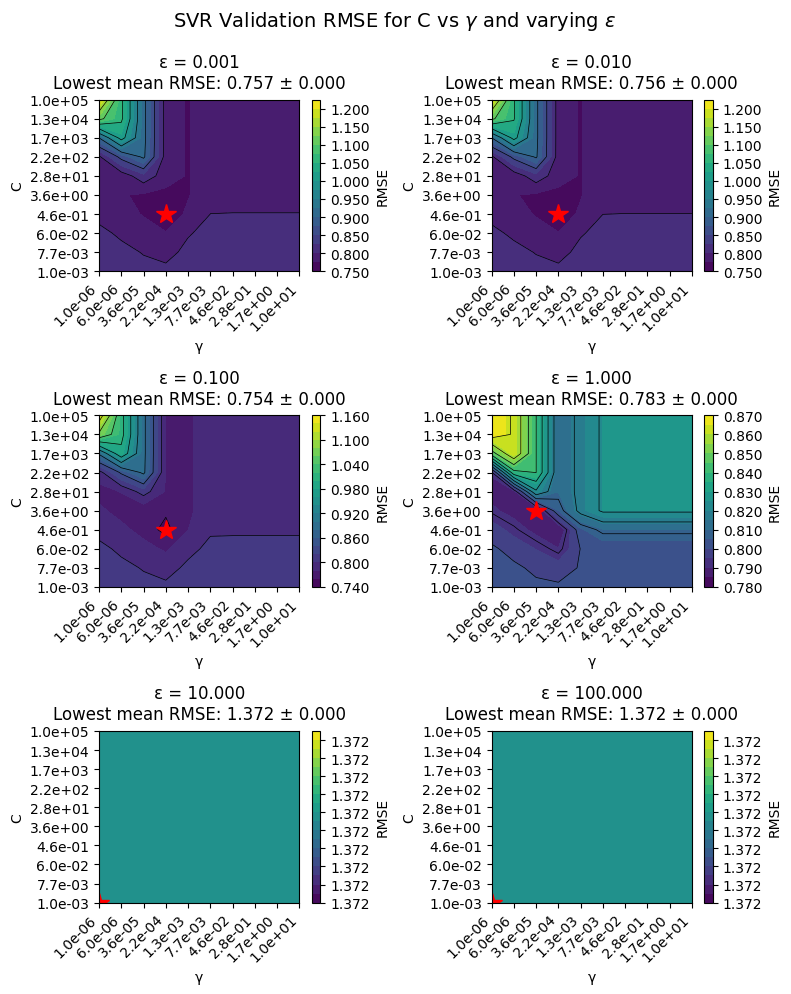


Global best:       ε=0.100,       C=0.464,       γ=0.000,       RMSE=0.754 ± 0.000


In [20]:
rmse = np.load('svr_rmse.npy', allow_pickle=True)
rmse_std = np.load('svr_rmse_std.npy', allow_pickle=True)

# print(rmse)
# print(rmse_std)

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes = axes.flatten()

for idx, eps in enumerate(epsilons):
    rmse_slice = rmse[idx, :, :]  # Shape: (len(Cs), len(gammas))
    rmse_std_slice = rmse_std[idx, :, :]  # Shape: (len(Cs), len(gammas))
    
    XX, YY = np.meshgrid(np.arange(len(gammas)), np.arange(len(Cs)))
    im = axes[idx].contourf(XX, YY, rmse_slice, levels=20, cmap='viridis')
    axes[idx].contour(XX, YY, rmse_slice, levels=10, colors='k', linewidths=0.5)
    
    # Find best for this epsilon
    best_idx = np.unravel_index(np.argmin(rmse_slice), rmse_slice.shape)
    axes[idx].plot(best_idx[1], best_idx[0], marker='*', color='red', markersize=15)
    
    # Get std at the best point
    best_std = rmse_std_slice[best_idx]
    print(f"C: {Cs[best_idx[0]]}, g: {gammas[best_idx[0]]}")
    
    axes[idx].set_title(f'ε = {eps:.3f}\nLowest mean RMSE: {rmse_slice[best_idx]:.3f} ± {best_std:.3f}', y=1.02)
    axes[idx].set_xlabel('γ')
    axes[idx].set_ylabel('C')
    axes[idx].set_xticks(np.arange(len(gammas)))
    axes[idx].set_xticklabels([f'{g:.1e}' for g in gammas], rotation=45, ha='right')
    axes[idx].set_yticks(np.arange(len(Cs)))
    axes[idx].set_yticklabels([f'{c:.1e}' for c in Cs])

    cbar = plt.colorbar(im, ax=axes[idx], label='RMSE', format='%.3f')
    cbar.update_ticks()

plt.suptitle('SVR Validation RMSE for C vs $\gamma$ and varying $\epsilon$', y=0.99, fontsize=14)
plt.tight_layout()
plt.show()

# Find global best
best_global = np.unravel_index(np.argmin(rmse), rmse.shape)
best_epsilon = epsilons[best_global[0]]
best_C = Cs[best_global[1]]
best_gamma = gammas[best_global[2]]
best_std = rmse_std[best_global]
print(f"\nGlobal best: \
      ε={best_epsilon:.3f}, \
      C={best_C:.3f}, \
      γ={best_gamma:.3f}, \
      RMSE={rmse[best_global]:.3f} ± {best_std:.3f}"
    )

In [16]:
svr = SVR(kernel='rbf', gamma=best_gamma, C=best_C, epsilon=0.001)
svr.fit(x_use, y_use)
y_hat = svr.predict(x_test)
y_hat = np.maximum(y_hat, 0)

final_rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print(f"Final RMSE: {final_rmse}")

Final RMSE: 0.7816206015697912
